# Create results from totalVI model

Zoë Steier

* Dataset: SLN-all (spleen and lymph node, two days, two panels)
* Generate denoised data, save updated anndata object, and write csvs to use for Vision.

## Imports and settings

In [1]:
# Import required packages

import os
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc
import pandas as pd

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

set_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

## Load data

In [4]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values


dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206],)

[2020-05-06 08:50:47,441] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-06 08:50:47,445] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 08:50:47,554] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 08:50:47,664] INFO - scvi.dataset.dataset | Downsampled from 16828 to 16828 cells
[2020-05-06 08:50:48,536] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-06 08:50:48,538] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 08:50:48,642] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 08:50:48,745] INFO - scvi.dataset.dataset | Downsampled from 15820 to 15820 cells
[2020-05-06 08:50:49,027] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-05-06 08:50:49,265] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 08:50:49,440] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-

In [5]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 32648 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'protein_expression', 'local_vars', 'local_means', 'labels', 'batch_indices'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

## Load and evaluate model

In [6]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset.n_batches,
)

In [7]:
model.load_state_dict(torch.load("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/sln_all_intersect.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4119, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [8]:
use_cuda = True
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

## Generate and save model outputs

In [9]:
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [10]:
post_adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/sln_all_intersect_post_adata.h5ad")

In [11]:
post_adata

AnnData object with n_obs × n_vars = 32648 × 4005 
    obs: 'leiden_totalVI_1.0', 'leiden_totalVI_0.8', 'leiden_totalVI_0.6', 'leiden_totalVI_0.4'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_totalVI', 'X_umap'

In [12]:
# Read annotations

annotations = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/annotations/annotations_subclustered.csv")

In [13]:
# Add annotations to anndata object

post_adata.obs["annotations"] = annotations["labels"].values
post_adata.obs["leiden_subclusters"] = annotations["leiden_subclusters"].values

... storing 'annotations' as categorical
... storing 'leiden_subclusters' as categorical


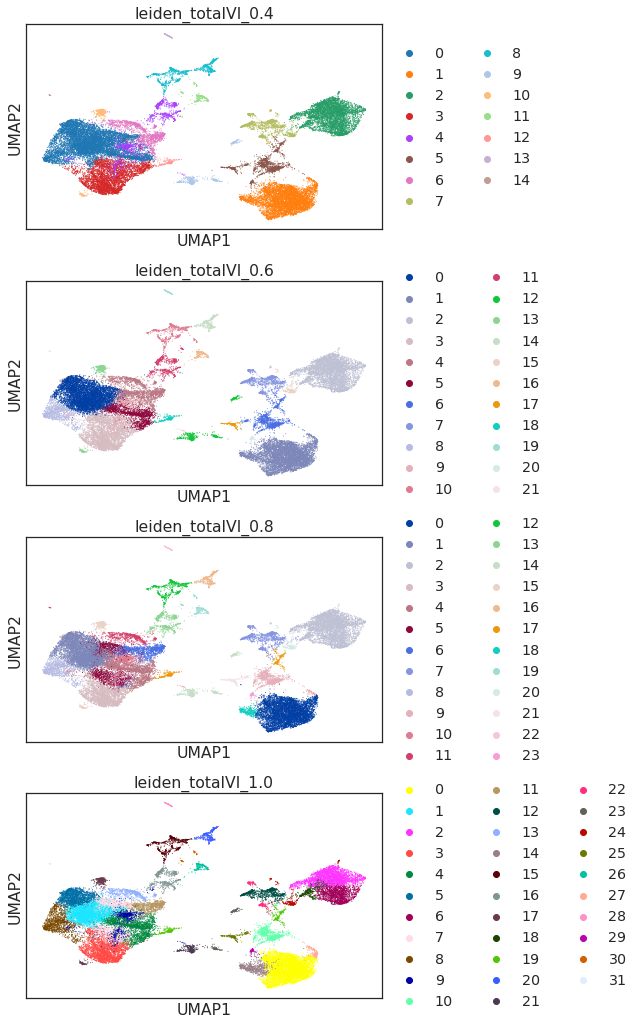

In [23]:
sc.pl.umap(
    post_adata, 
    color=["leiden_totalVI_0.4", "leiden_totalVI_0.6", "leiden_totalVI_0.8", "leiden_totalVI_1.0"],
    ncols=1
)

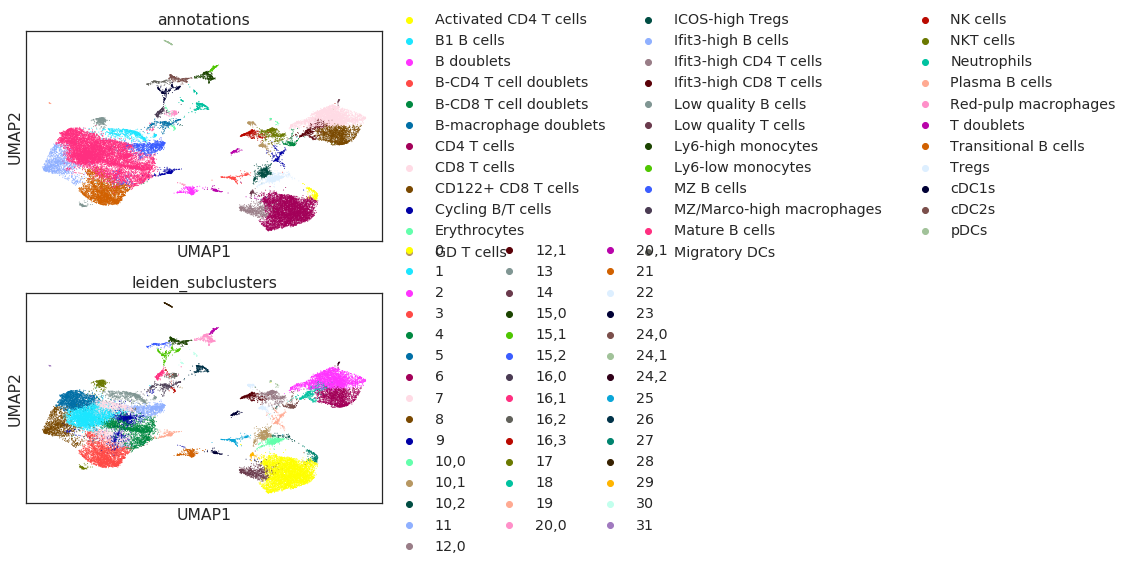

In [24]:
sc.pl.umap(
    post_adata, 
    color=["annotations", "leiden_subclusters",],
    ncols=1
)

In [14]:
# calculate protein background probabilities

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Number of Monte Carlo samples to average over
n_samples = 25

# Probability of background
py_mixing = np.mean(sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=False)
), axis=-1)
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=dataset.protein_names
)

In [15]:
# denoised data

denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch = 0) 

# Tranform batch puts all denoised samples into the same batch
# Here, choose WT day 1
# Input a list to average over all batches if give_mean = True

In [16]:
# concatenate raw anndatasets to collect metadata

adata_total = anndata.AnnData.concatenate(anndataset_111[:, hvg_111], anndataset_206[:, hvg_206])

In [17]:
adata_total

AnnData object with n_obs × n_vars = 32648 × 4005 
    obs: 'batch', 'batch_indices', 'cell_types', 'hash_id', 'leiden_subclusters', 'n_genes', 'n_protein_counts', 'n_proteins', 'percent_mito', 'seurat_hash_id'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'

In [18]:
# Add data and metadata from raw adata_total object to post_adata

# Add denoised counts to anndata
post_adata.obsm["denoised_proteins"] = denoised_proteins
post_adata.obsm["denoised_genes"] = denoised_genes

# Add raw protein counts
post_adata.obsm["protein_expression"] = dataset.protein_expression

# Add to anndata totalVI gene and protein names
post_adata.uns["totalVI_proteins"] = dataset.protein_names
post_adata.uns["totalVI_genes"] = dataset.gene_names

# Add metadata
post_adata.obs["batch_indices"] = [str(b[0]) for b in dataset.batch_indices]
post_adata.obs["n_genes"] = np.array(adata_total.obs["n_genes"])
post_adata.obs["n_protein_counts"] = np.array(adata_total.obs["n_protein_counts"])
post_adata.obs["n_proteins"] = np.array((post_adata.obsm["protein_expression"] > 0).sum(axis = 1))
post_adata.obs["n_RNA_counts"] = np.array(post_adata.X.sum(axis = 1))
post_adata.obs["percent_mito"] = np.array(adata_total.obs["percent_mito"])
post_adata.obs["seurat_hash_id"] = np.array(adata_total.obs["seurat_hash_id"])

# Add gene info
post_adata.var["highly_variable"] = adata_total.var["highly_variable"]
post_adata.var["encode"] = adata_total.var["encode"]
post_adata.var["hvg_encode"] = adata_total.var["hvg_encode"]

# Add cell info
cell_bc = np.concatenate((anndataset_111.obs.index.values, anndataset_206.obs.index.values))
post_adata.obs.index = cell_bc

In [19]:
# Add denoised protein counts and foreground probabilities for plotting

for i, p in enumerate(dataset.protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{}".format(p)] = denoised_proteins[:, i]

In [20]:
post_adata

AnnData object with n_obs × n_vars = 32648 × 4005 
    obs: 'leiden_totalVI_1.0', 'leiden_totalVI_0.8', 'leiden_totalVI_0.6', 'leiden_totalVI_0.4', 'annotations', 'leiden_subclusters', 'batch_indices', 'n_genes', 'n_protein_counts', 'n_proteins', 'n_RNA_counts', 'percent_mito', 'seurat_hash_id', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', '

## Save results

In [33]:
# Save anndata
post_adata.write("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/totalVI/sln_all_intersect_results_post_adata.h5ad", compression="gzip")

... storing 'batch_indices' as categorical
... storing 'seurat_hash_id' as categorical
... storing 'encode' as categorical


In [21]:
# Extract dataframes from anndata

# Obsm (latent space, UMAP, denoised proteins, denoised genes)
latent_df = pd.DataFrame(post_adata.obsm["X_totalVI"])
umap_df = pd.DataFrame(post_adata.obsm["X_umap"])
denoised_proteins_df = pd.DataFrame(post_adata.obsm["denoised_proteins"])
raw_proteins_df = pd.DataFrame(post_adata.obsm["protein_expression"])

# Uns (gene and protein names)
totalVI_genes_df = pd.DataFrame(post_adata.uns["totalVI_genes"])
totalVI_proteins_df = pd.DataFrame(post_adata.uns["totalVI_proteins"])

# X (the gene data matrix)
raw_genes_df = pd.DataFrame(post_adata.X)

# Obs
obs_df = pd.DataFrame(post_adata.obs)

In [70]:
# Write csvs for Vision, compress with .gz
# Note: this will take a few minutes. Avoid running this multiple times (only necessary to save the raw data once).

results_path = "/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/totalVI/"
latent_df.to_csv(results_path + "latent.csv.gz")
umap_df.to_csv(results_path + "umap.csv.gz")
denoised_proteins_df.to_csv(results_path + "denoised_proteins.csv.gz")
raw_proteins_df.to_csv(results_path + "raw_proteins.csv.gz")
totalVI_genes_df.to_csv(results_path + "totalVI_genes.csv.gz")
totalVI_proteins_df.to_csv(results_path + "totalVI_proteins.csv.gz")
raw_genes_df.to_csv(results_path + "raw_genes.csv.gz")
obs_df.to_csv(results_path + "obs.csv.gz", index = True)